In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

import json

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [21]:
from keras.callbacks import ModelCheckpoint

In [2]:
BATCH_SIZE = 32
EPOCHS = 200
IMG_SIZE = 224
LABELS = ["female", "male"]
initial_epochs = 100
fine_tune_epochs = 100
# Fine-tune from this layer onwards
fine_tune_at = 100

In [3]:
# Load the datasets
# In this POC, perturbed data refers to facial data processed with makeup
preprocessing_fp = "preprocessing"

In [4]:
IMG_SIZE = (224,224)
train_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "train_data_full"),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 86744 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "val_data_full"),
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 10955 files belonging to 2 classes.


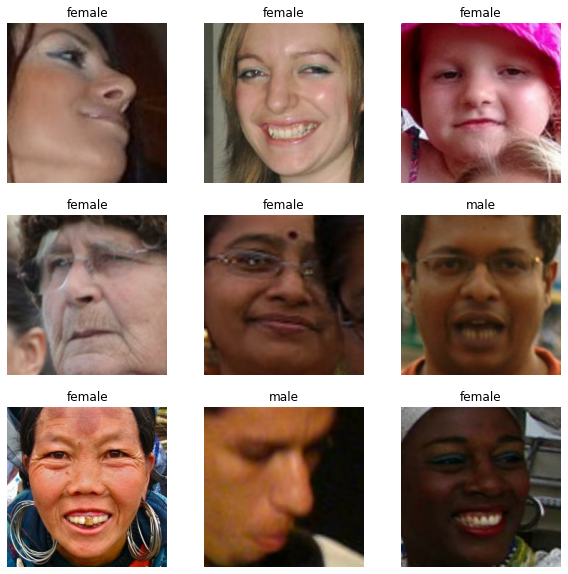

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 275
Number of test batches: 68


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

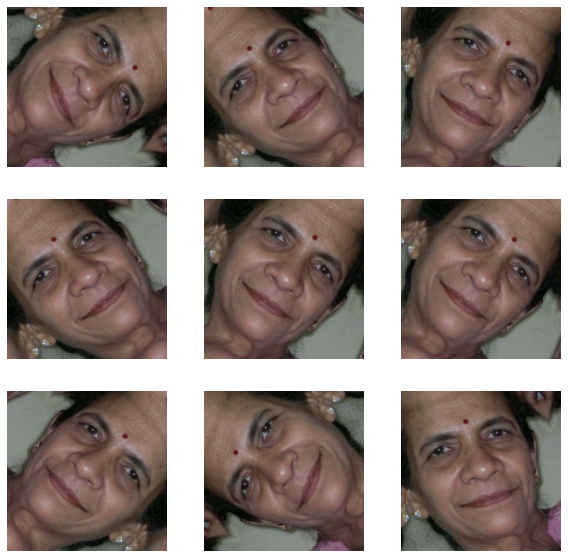

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [15]:
base_model.trainable = False

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


# Beginning of Model Training
## Unperturbed model

In [18]:
# Model creation
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model_pert = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_pert.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

loss0, accuracy0 = model.evaluate(validation_dataset)

275/275 [==============================] - 7s 18ms/step - loss: 0.7864 - accuracy: 0.5190


In [19]:
# Save a checkpoint of the model for later use
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

Epoch 1/100
2711/2711 [==============================] - 58s 21ms/step - loss: 0.6535 - accuracy: 0.6058 - val_loss: 0.5730 - val_accuracy: 0.6647
Epoch 2/100
2711/2711 [==============================] - 56s 21ms/step - loss: 0.6062 - accuracy: 0.6447 - val_loss: 0.5567 - val_accuracy: 0.6763
Epoch 3/100
2711/2711 [==============================] - 56s 21ms/step - loss: 0.5898 - accuracy: 0.6575 - val_loss: 0.5478 - val_accuracy: 0.6898
Epoch 4/100
2711/2711 [==============================] - 55s 20ms/step - loss: 0.5810 - accuracy: 0.6666 - val_loss: 0.5429 - val_accuracy: 0.6914
Epoch 5/100
2711/2711 [==============================] - 55s 20ms/step - loss: 0.5762 - accuracy: 0.6671 - val_loss: 0.5416 - val_accuracy: 0.6860
Epoch 6/100
2711/2711 [==============================] - 55s 20ms/step - loss: 0.5729 - accuracy: 0.6707 - val_loss: 0.5384 - val_accuracy: 0.6903
Epoch 7/100
2711/2711 [==============================] - 55s 20ms/step - loss: 0.5719 - accuracy: 0.6722 - val_loss: 0

In [22]:
total_epochs =  initial_epochs + fine_tune_epochs

checkpoint = ModelCheckpoint(
    "model_tl_best_weights.h5",
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_freq="epoch",
)

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                        callbacks=[checkpoint])

# Store model history as a JSON file
with open(os.path.join("history", "model_tl_history.json"), "w") as f:
    json.dump(history_fine.history, f) # Construct the baseline (unperturbed) model

Epoch 100/200
2711/2711 [==============================] - 59s 21ms/step - loss: 0.5643 - accuracy: 0.6803 - val_loss: 0.5304 - val_accuracy: 0.7003
Epoch 101/200
2711/2711 [==============================] - 57s 21ms/step - loss: 0.5608 - accuracy: 0.6821 - val_loss: 0.5296 - val_accuracy: 0.7011
Epoch 102/200
2711/2711 [==============================] - 57s 21ms/step - loss: 0.5630 - accuracy: 0.6820 - val_loss: 0.5302 - val_accuracy: 0.6996
Epoch 103/200
2711/2711 [==============================] - 57s 21ms/step - loss: 0.5637 - accuracy: 0.6812 - val_loss: 0.5295 - val_accuracy: 0.6999
Epoch 104/200
2711/2711 [==============================] - 56s 21ms/step - loss: 0.5633 - accuracy: 0.6817 - val_loss: 0.5294 - val_accuracy: 0.7025
Epoch 105/200
2711/2711 [==============================] - 56s 21ms/step - loss: 0.5637 - accuracy: 0.6816 - val_loss: 0.5291 - val_accuracy: 0.7038
Epoch 106/200
2711/2711 [==============================] - 56s 21ms/step - loss: 0.5637 - accuracy: 0.6811

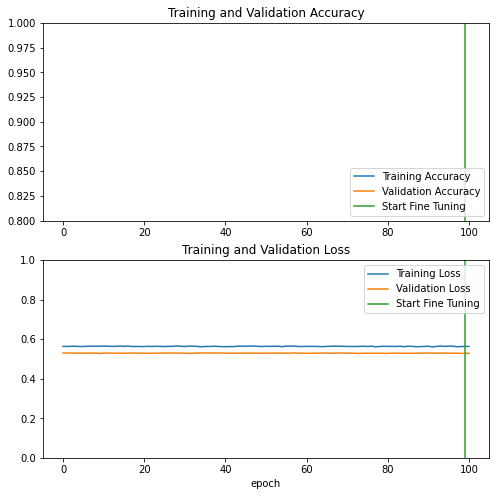

In [26]:
acc = []
val_acc = []
loss = []
val_loss = []

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Perturbed Model

In [27]:
train_pert_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "makeup_full"),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 63938 files belonging to 2 classes.


In [28]:
# Save a checkpoint of the model for later use
history = model_pert.fit(train_pert_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model_pert.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

Epoch 1/100
1999/1999 [==============================] - 74s 36ms/step - loss: 0.5761 - accuracy: 0.6712 - val_loss: 0.5642 - val_accuracy: 0.7216
Epoch 2/100
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5595 - accuracy: 0.6861 - val_loss: 0.5623 - val_accuracy: 0.7184
Epoch 3/100
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5490 - accuracy: 0.6938 - val_loss: 0.5646 - val_accuracy: 0.7172
Epoch 4/100
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5522 - accuracy: 0.6936 - val_loss: 0.5659 - val_accuracy: 0.7142
Epoch 5/100
1999/1999 [==============================] - 73s 37ms/step - loss: 0.5492 - accuracy: 0.6979 - val_loss: 0.5728 - val_accuracy: 0.7144
Epoch 6/100
1999/1999 [==============================] - 73s 36ms/step - loss: 0.5460 - accuracy: 0.6983 - val_loss: 0.5740 - val_accuracy: 0.7123
Epoch 7/100
1999/1999 [==============================] - 73s 36ms/step - loss: 0.5460 - accuracy: 0.6972 - val_loss: 0

In [30]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

checkpoint_pert = ModelCheckpoint(
    "model_tl_pert_best_weights.h5",
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_freq="epoch",
)

history_fine = model_pert.fit(train_pert_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                        callbacks=[checkpoint_pert])

# Store model history as a JSON file
with open(os.path.join("history", "model_tl_pert_history.json"), "w") as f:
    json.dump(history_fine.history, f) # Construct the baseline (unperturbed) model

Epoch 100/200
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5383 - accuracy: 0.7039 - val_loss: 0.5872 - val_accuracy: 0.7027
Epoch 101/200
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5419 - accuracy: 0.7030 - val_loss: 0.5848 - val_accuracy: 0.7009
Epoch 102/200
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5410 - accuracy: 0.7036 - val_loss: 0.5857 - val_accuracy: 0.7014
Epoch 103/200
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5414 - accuracy: 0.7031 - val_loss: 0.5840 - val_accuracy: 0.7018
Epoch 104/200
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5423 - accuracy: 0.7029 - val_loss: 0.5862 - val_accuracy: 0.7016
Epoch 105/200
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5403 - accuracy: 0.7028 - val_loss: 0.5835 - val_accuracy: 0.7014
Epoch 106/200
1999/1999 [==============================] - 72s 36ms/step - loss: 0.5400 - accuracy: 0.7042

# Model Analysis

In [36]:
# Unravels batches
def unravel_batches(model):
    true_labels = []
    predicted = []

    for image_batch, label_batch in test_dataset.as_numpy_iterator():
        predictions = model.predict_on_batch(image_batch).flatten()
        predictions = tf.nn.sigmoid(predictions)
        predictions = tf.where(predictions < 0.5, 0, 1)
        true_labels.extend(label_batch)
        predicted.extend(predictions.numpy())
    return true_labels, predicted

In [37]:
true_labels, predicted = unravel_batches(model)
true_labels_pert, predicted_pert = unravel_batches(model_pert)

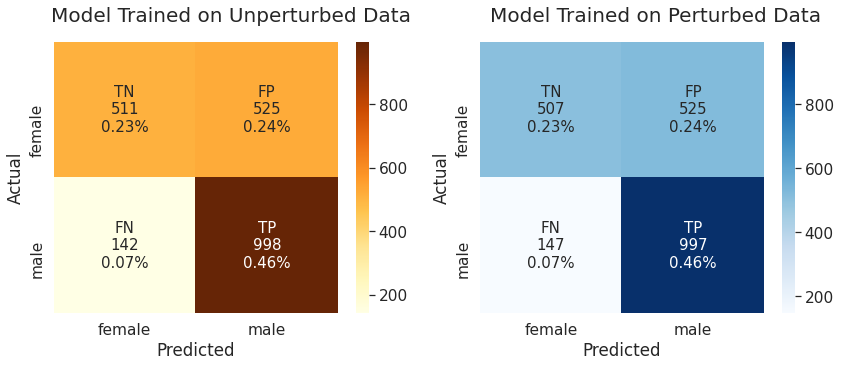

In [42]:
epochs_range = range(EPOCHS)

#fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(19, 10))
#fig.suptitle("Unperturbed vs Perturbed")
#fig.subplots_adjust(top=0.85)

cf_matrix = confusion_matrix(true_labels, predicted)
cf_matrix_pert = confusion_matrix(true_labels_pert, predicted_pert)

f, ax = plt.subplots(1, 2, sharex=True, figsize=(14, 5))

# Tweak graphs and add text
ext = [
    [72.0 * 2.5, 97.04347826086959 * 2.25],
    [188.4521739130435 * 2.25, 97.04347826086956 * 2.25],
    [304.904347826087 * 2.4, 97.04347826086956 * 2.4],
    [421.35652173913047 * 2.4, 97.04347826086962 * 2.4],
]

inv = fig.transFigure.inverted()
width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2.0
left_center = inv.transform((width_left, 1))
width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2.0
right_center = inv.transform((width_right, 1))

# Unperturbed data
group_names = ["TN", "FP", "FN", "TP"]
group_counts = map(round, cf_matrix.flatten())
group_percentages = (
    f"{round(value, 2)}%" for value in cf_matrix.flatten() / np.sum(cf_matrix)
)
df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
labels = np.asarray(
    ["\n".join(map(str, v)) for v in zip(group_names, group_counts, group_percentages)]
).reshape(2, 2)

# Perturbed data
group_counts_pert = map(round, cf_matrix_pert.flatten())
group_percentages_pert = (
    f"{round(value, 2)}%" for value in cf_matrix_pert.flatten() / np.sum(cf_matrix_pert)
)
df_cm_pert = pd.DataFrame(cf_matrix_pert, range(2), range(2))
df_cm_pert.index.name = "Actual"
df_cm_pert.columns.name = "Predicted"
labels_pert = np.asarray(
    [
        "\n".join(map(str, v))
        for v in zip(group_names, group_counts_pert, group_percentages_pert)
    ]
).reshape(2, 2)

# Confusion matrix titles
width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2
left_center = inv.transform((width_left, 1))
width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2
right_center = inv.transform((width_right, 1))
plt.figtext(
    left_center[0],
    0.95,
    "Model Trained on Unperturbed Data",
    va="center",
    ha="center",
    size=20,
)
plt.figtext(
    right_center[0],
    0.95,
    "Model Trained on Perturbed Data",
    va="center",
    ha="center",
    size=20,
)

sns.set(font_scale=1.4)  # for label size
sns.heatmap(
    df_cm,
    annot=labels,
    annot_kws={"size": 15},
    cmap="YlOrBr",
    fmt="",
    ax=ax[0],
    xticklabels=LABELS,
    yticklabels=LABELS,
)
sns.heatmap(
    df_cm_pert,
    annot=labels_pert,
    annot_kws={"size": 15},
    cmap="Blues",
    fmt="",
    ax=ax[1],
    xticklabels=LABELS,
    yticklabels=LABELS,
)
sns.set_style("darkgrid")
plt.show()

In [262]:
print(classification_report(
        true_labels, predicted, target_names=LABELS, zero_division=1
    )
)

              precision    recall  f1-score   support

      female       0.73      0.68      0.70       846
        male       0.72      0.76      0.74       914

    accuracy                           0.72      1760
   macro avg       0.72      0.72      0.72      1760
weighted avg       0.72      0.72      0.72      1760

